# **Multiclass Neural Network for Tifinagh Character Recognition**

This notebook implements a multilayer perceptron (MLP) to classify handwritten Tifinagh characters from the AMHCD dataset (28,182 images, 33 classes). It includes data preprocessing, model training, hyperparameter tuning, cross-validation, and evaluation, with bonus features: L2 regularization, Adam optimizer, K-fold cross-validation, and data augmentation.

## **1.Imports and Setup**
Import required libraries and set random seed for reproducibility.

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import sys
import time
import json
import shutil
import random
import zipfile
import itertools
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import trange, tqdm
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed for reproducibility
np.random.seed(42)

## **2.Activation Functions**
Define ReLU and Softmax activations for the MLP.

In [ ]:
# Activation Functions
def relu(x):
    """ReLU activation: max(0, x)"""
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1"
    return result


## **3.Data Augmentation and Preprocessing**
Functions for augmenting images (rotation, translation) and preprocessing (grayscale, resize, normalize).

In [ ]:
# Data Augmentation
def augment_image(image, max_rotation=10, max_translation=3):
    """Apply random rotation and translation to a 32x32 grayscale image"""
    assert image.shape == (32, 32), "Image must be 32x32"
    angle = np.random.uniform(-max_rotation, max_rotation)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (32, 32), borderMode=cv2.BORDER_REPLICATE)
    tx = np.random.uniform(-max_translation, max_translation)
    ty = np.random.uniform(-max_translation, max_translation)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(rotated, M, (32, 32), borderMode=cv2.BORDER_REPLICATE)
    return translated.flatten()

# Image Preprocessing
def load_and_preprocess_image(image_path, data_dir, target_size=(32, 32)):
    """Load and preprocess image: grayscale, resize, normalize"""
    full_path = os.path.join(data_dir, image_path)
    assert os.path.exists(full_path), f"Image not found: {full_path}"
    img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {full_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img.flatten()


## **4.Visualization**
Function to display sample images per Tifinagh class.

In [ ]:
# Visualization
def display_sample_images_from_paths(labels_df, data_dir, path_column='image_path', label_column='label',
                                     num_samples=33, samples_per_row=11, random_state=83):
    """Display a grid of sample grayscale images, one per class"""
    assert path_column in labels_df.columns, f"Missing column: {path_column}"
    assert label_column in labels_df.columns, f"Missing column: {label_column}"

    rng = np.random.default_rng(random_state)
    unique_labels = labels_df[label_column].unique()
    num_samples = min(num_samples, len(unique_labels))
    selected_indices = [rng.choice(labels_df[labels_df[label_column] == lbl].index)
                        for lbl in rng.choice(unique_labels, size=num_samples, replace=False)]
    selected_df = labels_df.loc[selected_indices].sort_values(by=label_column)

    num_rows = (num_samples + samples_per_row - 1) // samples_per_row
    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(samples_per_row * 2, num_rows * 3))
    axes = axes.ravel()

    for i, (path, label) in enumerate(zip(selected_df[path_column], selected_df[label_column])):
        try:
            img = Image.open(os.path.join(data_dir, path))
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label: {label}", fontsize=17)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {path}: {e}")
            axes[i].set_title("Error")
            axes[i].axis('off')

    for ax in axes[num_samples:]:
        ax.axis('off')

    plt.tight_layout()
    return fig

## **5.Neural Network Implementation**
MLP class with forward propagation, backpropagation, and training logic.

In [ ]:
# Neural Network Class
class MulticlassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.01, optimizer='sgd', beta1=0.9, beta2=0.999, epsilon=1e-8):
        """Initialize MLP with specified architecture and parameters"""
        assert len(layer_sizes) >= 2, "At least 2 layers required"
        assert all(size > 0 for size in layer_sizes), "Layer sizes must be positive"
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.optimizer = optimizer.lower()
        self.beta1, self.beta2, self.epsilon = beta1, beta2, epsilon
        self.weights = []
        self.biases = []
        self.m_weights, self.v_weights = [], []
        self.m_biases, self.v_biases = [], []
        self.t = 0

        # He initialization
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)
            self.m_weights.append(np.zeros_like(w))
            self.v_weights.append(np.zeros_like(w))
            self.m_biases.append(np.zeros_like(b))
            self.v_biases.append(np.zeros_like(b))

    def forward(self, X):
        """Forward propagation"""
        self.z_values, self.activations = [], [X]
        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(Z)
            self.activations.append(relu(Z))
        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(Z)
        output = softmax(Z)
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        """Cross-entropy loss with L2 regularization"""
        m = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy = -np.sum(y_true * np.log(y_pred_clipped)) / m
        l2_term = (self.l2_lambda / (2 * m)) * sum(np.sum(np.square(W)) for W in self.weights)
        total_loss = cross_entropy + l2_term
        assert not np.isnan(total_loss), "Loss is NaN"
        return total_loss

    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy"""
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y):
        """Backpropagation"""
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = self.activations[-1] - y
        self.d_weights[-1] = (np.dot(self.activations[-2].T, dZ) + self.l2_lambda * self.weights[-1]) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = dZ
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dA_prev, self.weights[i + 1].T)
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (np.dot(self.activations[i].T, dZ) + self.l2_lambda * self.weights[i]) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            dA_prev = dZ

    def update_parameters(self):
        """Update parameters using SGD or Adam"""
        if self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.d_weights[i]
                self.biases[i] -= self.learning_rate * self.d_biases[i]
        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(len(self.weights)):
                self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
                self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
                self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
                m_w_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
                m_b_hat = self.m_biases[i] / (1 - self.beta1 ** self.t)
                v_b_hat = self.v_biases[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs=100, batch_size=100, augment=False, early_stopping=True, verbose=1):
        """Train the MLP"""
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        best_val_loss = np.inf
        best_weights = [w.copy() for w in self.weights]
        best_biases = [b.copy() for b in self.biases]
        patience, patience_counter = 10, 0

        for epoch in range(epochs):
            start_time = time.time()

            indices = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[indices], y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                if augment:
                    X_batch = np.array([augment_image(img.reshape(32, 32)) for img in X_batch])
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch)
                self.update_parameters()

            train_pred = self.forward(X)
            val_pred = self.forward(X_val)
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            val_loss = self.compute_loss(y_val, val_pred)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            end_time = time.time()
            epoch_time = end_time - start_time

            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = [w.copy() for w in self.weights]
                    best_biases = [b.copy() for b in self.biases]
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose >= 1:
                            print(f"Early stopping at epoch {epoch + 1}")
                        self.weights = best_weights
                        self.biases = best_biases
                        break

            log = (epoch % 10 == 0 or epoch == epochs - 1)
            if verbose == 2 and log:
                print(f"Epoch {epoch + 1:03d} | Time: {epoch_time:.2f}s | "
                      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                      f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")
            elif verbose == 1 and log:
                print(f"\nEpoch {epoch + 1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                      f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies



    def predict(self, X):
        """Predict class labels"""
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)


## **6.K-Fold Cross-Validation**
Function for K-fold cross-validation to evaluate model robustness.

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y_one_hot, layer_sizes, k=5, epochs=100, batch_size=32,
                            learning_rate=0.001, l2_lambda=0.01, optimizer='sgd',
                            augment=False, early_stopping=False, verbose=1):
    assert isinstance(X, np.ndarray) and isinstance(y_one_hot, np.ndarray), "X and y_one_hot must be numpy arrays"
    assert X.shape[0] == y_one_hot.shape[0], "X and y_one_hot must have the same number of samples"
    assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
    assert isinstance(k, int) and k > 1, "k must be an integer greater than 1"
    assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
    assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"
    assert optimizer.lower() in ['sgd', 'adam'], "Optimizer must be 'sgd' or 'adam'"

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    all_splits = list(kf.split(X))

    for fold in trange(k, desc="Cross-validation folds", disable=(verbose == 0)):
        train_idx, val_idx = all_splits[fold]

        if verbose >= 1:
            print(f"\n=========================== Fold {fold + 1}/{k} ===========================================\n")
        start_time = time.time()

        X_train, X_val = X[train_idx], X[val_idx]
        y_train_one_hot, y_val_one_hot = y_one_hot[train_idx], y_one_hot[val_idx]

        nn = MulticlassNeuralNetwork(
            layer_sizes, learning_rate=learning_rate, l2_lambda=l2_lambda, optimizer=optimizer
        )

        train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
            X_train, y_train_one_hot, X_val, y_val_one_hot,
            epochs=epochs, batch_size=batch_size,
            augment=augment, early_stopping=early_stopping, verbose=verbose
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(val_accuracies)

        final_val_accuracy = val_accuracies[-1]
        if verbose >= 2:
            y_val_pred = nn.predict(X_val)
            print(f"\n===========================Fold {fold + 1} Classification Report: =======================")
            print(classification_report(np.argmax(y_val_one_hot, axis=1), y_val_pred))

        if verbose >= 1:
            print(f"Fold {fold + 1} completed in {time.time() - start_time:.2f} seconds")
            print(f"Final validation accuracy: {final_val_accuracy:.4f}")

    avg_train_losses = np.mean(fold_train_losses, axis=0)
    avg_val_losses = np.mean(fold_val_losses, axis=0)
    avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
    avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

    if verbose >= 1:
        print(f"\n=========================== Cross-Validation Summary ===========================")
        print(f"Average final validation accuracy: {avg_val_accuracies[-1]:.4f}")
        print(f"Metrics computed over {epochs} epochs")

    return avg_train_losses, avg_val_losses, avg_train_accuracies, avg_val_accuracies

## **7.Dataset Loading and Preprocessing**
Load AMHCD dataset, preprocess images, encode labels, and split data.

### **7.1. Extracting & Loading AMHCD DataSet**

In [ ]:
def cleanup(base_dir="/content/", temp_dir="temp"):
    temp_dir = os.path.join(base_dir, temp_dir)
    shutil.rmtree(temp_dir, ignore_errors=True)
    print(f"{temp_dir} Cleaned up.")

In [ ]:
# Download latest version
path = kagglehub.dataset_download("benaddym/amazigh-handwritten-character-database-amhcd")

target_dir = "/content/amhcd"
cleanup(temp_dir=target_dir)
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("Path to dataset files:", target_dir)

/content/amhcd Cleaned up.
Path to dataset files: /content/amhcd


In [ ]:
latin_labels_txt    = target_dir + '/labels/labels/33-common-latin-tifinagh.txt'

tifinagh_labels_txt = target_dir + '/labels/labels/sorted-33-common-tifinagh.txt'
images_root         = target_dir + '/AMHCD_64/AMHCD_64'
output_csv          = target_dir + '/rgb-labels-map.csv'

# Lire les labels Latin et les glyphes Tifinagh
with open(latin_labels_txt, 'r', encoding='utf-8') as f:
    ascii_labels = [line.strip() for line in f if line.strip()]

with open(tifinagh_labels_txt, 'r', encoding='utf-8') as f:
    tif_chars = [line.strip() for line in f if line.strip()]

#  Vérification
if len(ascii_labels) != len(tif_chars):
    print(f"Erreur : {len(ascii_labels)} labels Latin ≠ {len(tif_chars)} glyphes Tifinagh")
    sys.exit(1)



In [ ]:
# Génération du CSV
with open(output_csv, 'w', encoding='utf-8', newline='') as out:
    for latin, tif in zip(ascii_labels, tif_chars):
        folder = os.path.join(images_root, latin)
        if not os.path.isdir(folder):
            print(f"Dossier introuvable, je passe : {folder}")
            continue
        for fname in sorted(os.listdir(folder)):
            # filtrer si nécessaire par extension d’image
            if not fname.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tif','.tiff')):
                continue
            rel_path = f"{images_root}/{latin}/{fname}"
            # Écrire UNE ligne contenant chemin + glyphe
            out.write(f"{rel_path},{tif}\n")

print(f"Généré {output_csv} avec {sum(len(os.listdir(os.path.join(images_root,l))) for l in ascii_labels if os.path.isdir(os.path.join(images_root,l)))} entrées.")

Généré /content/amhcd/rgb-labels-map.csv avec 25740 entrées.


In [ ]:
labels_df = pd.read_csv(output_csv, names=['image_path', 'label'])

In [ ]:
# Debugging: Print sample paths
print("Sample image paths:")
for path in labels_df['image_path'].head(5):
    full_path = os.path.join(target_dir, path)
    print(f"{full_path} -> Exists: {os.path.exists(full_path)}")

print(f"\nLoaded {len(labels_df)} samples with {labels_df['label'].nunique ()} unique classes .")

Sample image paths:
/content/amhcd/AMHCD_64/AMHCD_64/ya/ya_1.jpeg -> Exists: True
/content/amhcd/AMHCD_64/AMHCD_64/ya/ya_10.jpeg -> Exists: True
/content/amhcd/AMHCD_64/AMHCD_64/ya/ya_100.jpeg -> Exists: True
/content/amhcd/AMHCD_64/AMHCD_64/ya/ya_101.jpeg -> Exists: True
/content/amhcd/AMHCD_64/AMHCD_64/ya/ya_102.jpeg -> Exists: True

Loaded 25740 samples with 33 unique classes .


In [ ]:
class_counts = labels_df['label'].value_counts()
print("Class distribution summary:")
print(f"Min: {class_counts.min()}, Max: {class_counts.max()}, Mean: {class_counts.mean():.2f}")

Class distribution summary:
Min: 780, Max: 780, Mean: 780.00


In [ ]:
print("Label encoding ...")
# Encode labels
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

print("==================== Data with label encoded: ======================")
print(labels_df)

Label encoding ...
==================== Data with label encoded: ======================
                                            image_path label  label_encoded
0        /content/amhcd/AMHCD_64/AMHCD_64/ya/ya_1.jpeg     ⴰ              0
1       /content/amhcd/AMHCD_64/AMHCD_64/ya/ya_10.jpeg     ⴰ              0
2      /content/amhcd/AMHCD_64/AMHCD_64/ya/ya_100.jpeg     ⴰ              0
3      /content/amhcd/AMHCD_64/AMHCD_64/ya/ya_101.jpeg     ⴰ              0
4      /content/amhcd/AMHCD_64/AMHCD_64/ya/ya_102.jpeg     ⴰ              0
...                                                ...   ...            ...
25735   /content/amhcd/AMHCD_64/AMHCD_64/yu/yu_95.jpeg     ⵓ             20
25736   /content/amhcd/AMHCD_64/AMHCD_64/yu/yu_96.jpeg     ⵓ             20
25737   /content/amhcd/AMHCD_64/AMHCD_64/yu/yu_97.jpeg     ⵓ             20
25738   /content/amhcd/AMHCD_64/AMHCD_64/yu/yu_98.jpeg     ⵓ             20
25739   /content/amhcd/AMHCD_64/AMHCD_64/yu/yu_99.jpeg     ⵓ             20


In [ ]:
print(f"Class distribution:")
# display(labels_df['label'].value_counts())
display(labels_df[['label', 'label_encoded']].value_counts())

Class distribution:


,,count
label,label_encoded,
ⴰ,0,780
ⴱ,1,780
ⴳ,2,780
ⴳⵯ,3,780
ⴷ,4,780
ⴹ,5,780
ⴻ,6,780
ⴼ,7,780
ⴽ,8,780


In [ ]:
# Load images
X = np.array([load_and_preprocess_image(path, target_dir) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Verify dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32 * 32}, got {X.shape[1]}"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

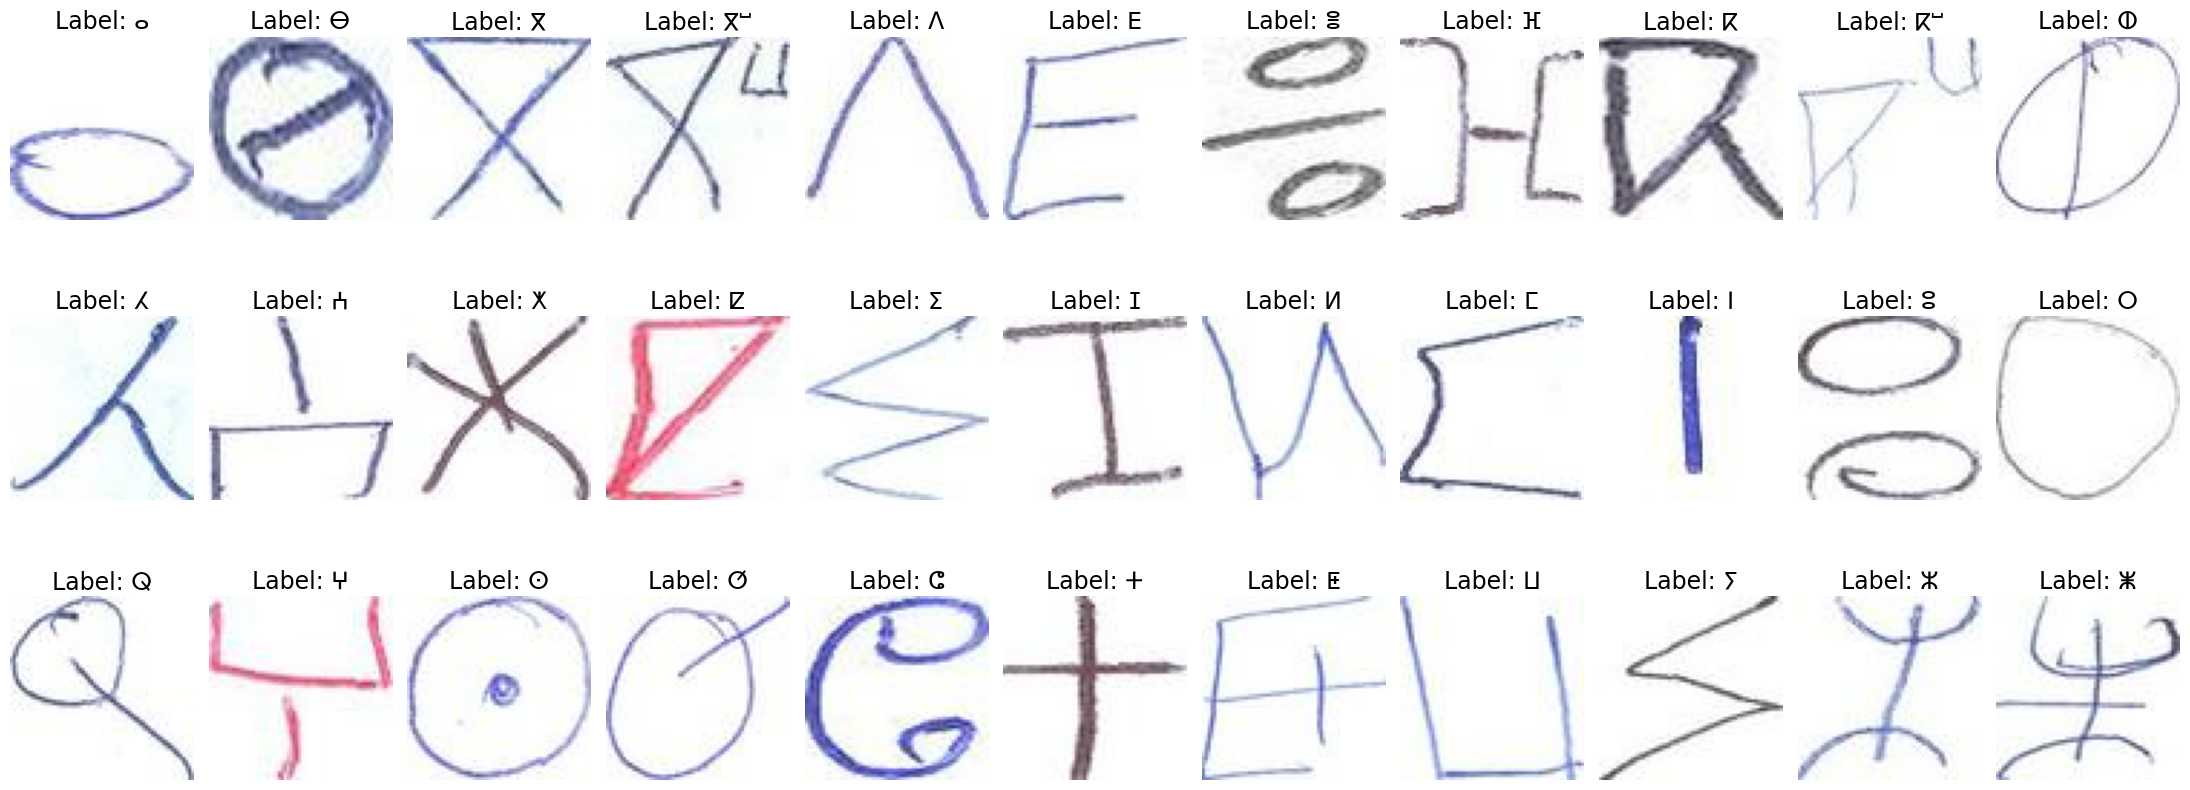

In [ ]:
fig = display_sample_images_from_paths(labels_df, target_dir, random_state=4)
plt.savefig('sample_images1.png')
files.download('sample_images1.png')
plt.close()


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 15444, Val: 5148, Test: 5148


# **8.Hyperparameter Tuning**


In [ ]:
layer_sizes = [32 * 32, 64, 32, num_classes]
param_distributions = {
    'learning_rate': [0.01, 0.001],
    'l2_lambda': [0.01, 0.001],
    'batch_size': [64, 32],
    'optimizer': ['adam', 'sgd']
}

n_iter = 16

# All possible combinations
keys = list(param_distributions.keys())
all_combinations = [
    dict(zip(keys, values))
    for values in itertools.product(*param_distributions.values())
]

# Shuffle and pick n_iter unique combinations
random.shuffle(all_combinations)
random_param_combinations  = all_combinations[:n_iter]

assert len(random_param_combinations) == len(set(tuple(sorted(p.items())) for p in random_param_combinations)), "Duplicate combinations found!"

results = []
best_val_accuracy = 0
best_params = None

In [ ]:
# ===================== Random Search + CV Loop =======================

for i in trange(n_iter, desc="Random Search"):
    params = random_param_combinations[i]
    print(f"\nTrial {i + 1}/{n_iter}: {params}")
    avg_train_losses, avg_val_losses, avg_train_accuracies, avg_val_accuracies = k_fold_cross_validation(
        X_train, y_train_one_hot, layer_sizes, k=5, epochs=100, **params, augment=True, verbose=2
    )
    final_val_accuracy = avg_val_accuracies[-1]
    results.append({'trial': i + 1, 'params': params, 'final_val_accuracy': final_val_accuracy})
    if final_val_accuracy > best_val_accuracy:
        best_val_accuracy = final_val_accuracy
        best_params = params

In [ ]:
# ===================== Result Summary & Best Pick ========================
df = pd.DataFrame([
    {
        'Trial': r['trial'],
        'learning_rate': r['params']['learning_rate'],
        'l2_lambda': r['params']['l2_lambda'],
        'batch_size': r['params']['batch_size'],
        'optimizer': r['params']['optimizer'],
        'val_accuracy': r['final_val_accuracy']
    }
    for r in results
]).sort_values(by='val_accuracy', ascending=False).reset_index(drop=True)

display(df)

df.to_csv('rs_results_summary.csv', index=False)
files.download('rs_results_summary.csv')


,Trial,learning_rate,l2_lambda,batch_size,optimizer,val_accuracy
0,13,0.001,0.001,32,sgd,0.774025
1,11,0.001,0.010,32,sgd,0.773959
2,1,0.001,0.010,64,adam,0.668105
3,10,0.001,0.001,64,adam,0.653790
4,14,0.001,0.010,64,sgd,0.572260
5,8,0.001,0.001,64,sgd,0.561315
6,12,0.010,0.001,32,sgd,0.498836
7,5,0.010,0.010,32,sgd,0.498509
8,15,0.001,0.010,32,adam,0.457582
9,16,0.010,0.001,64,sgd,0.401385


In [ ]:
# # ===================== Result Summary & Best Pick ========================
# results_df = pd.DataFrame([
#     {
#         'Trial': r['trial'],
#         'learning_rate': r['params']['learning_rate'],
#         'l2_lambda': r['params']['l2_lambda'],
#         'batch_size': r['params']['batch_size'],
#         'optimizer': r['params']['optimizer'],
#         'val_accuracy': r['final_val_accuracy']
#     }
#     for r in results
# ]).sort_values(by='val_accuracy', ascending=False).reset_index(drop=True)

# display(results_df)

# results_df.to_csv('rs_results_summary.csv', index=False)
# files.download('rs_results_summary.csv')

In [ ]:
# ========== Save best parameters and best validation accuracy + layer_sizes ==========
with open("random_search_results.json", "w") as f:
    json.dump({
        "best_params": best_params,
        "best_val_accuracy": best_val_accuracy,
        "layer_sizes": layer_sizes
    }, f)

files.download("random_search_results.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Perform k-fold cross-validation with SGD & Adam**


In [ ]:
# =================== Load saved random_search_results.json file ================
with open("random_search_results.json", "r") as f:
    data = json.load(f)
    best_params = data["best_params"]
    layer_sizes = data["layer_sizes"]
    best_val_accuracy = data["best_val_accuracy"]

learning_rate = best_params['learning_rate']
l2_lambda = best_params['l2_lambda']
batch_size = best_params['batch_size']
optimizer = best_params['optimizer']

### **9.1.Perform k-fold cross-validation with SGD**

In [ ]:
# Perform k-fold cross-validation with SGD
print("\n========================= K-Fold Cross-Validation with SGD (Augmented): ===========================")
avg_train_losses_sgd, avg_val_losses_sgd, avg_train_accuracies_sgd, avg_val_accuracies_sgd = k_fold_cross_validation(
    X_train, y_train_one_hot, layer_sizes, k=5, epochs=100, batch_size=batch_size, learning_rate=learning_rate, l2_lambda=l2_lambda, optimizer='sgd', augment=True,
)



========================= K-Fold Cross-Validation with SGD (Augmented): ===========================


Cross-validation folds:   0%|          | 0/5 [00:00<?, ?it/s]


=========================== Fold 1/5 ===========================================

Epoch 001 | Train Loss: 3.5065 | Val Loss: 3.4739 | Train Acc: 0.0436 | Val Acc: 0.0411
Epoch 011 | Train Loss: 3.3040 | Val Loss: 3.2679 | Train Acc: 0.1119 | Val Acc: 0.1107
Epoch 021 | Train Loss: 3.0354 | Val Loss: 2.9228 | Train Acc: 0.2059 | Val Acc: 0.2052
Epoch 031 | Train Loss: 2.5906 | Val Loss: 2.4504 | Train Acc: 0.3073 | Val Acc: 0.3134
Epoch 041 | Train Loss: 2.1948 | Val Loss: 1.9811 | Train Acc: 0.4526 | Val Acc: 0.4607
Epoch 051 | Train Loss: 1.9072 | Val Loss: 1.6445 | Train Acc: 0.5792 | Val Acc: 0.5762
Epoch 061 | Train Loss: 1.6926 | Val Loss: 1.3863 | Train Acc: 0.6408 | Val Acc: 0.6297
Epoch 071 | Train Loss: 1.5393 | Val Loss: 1.1187 | Train Acc: 0.7424 | Val Acc: 0.7472
Epoch 081 | Train Loss: 1.4321 | Val Loss: 1.0878 | Train Acc: 0.7009 | Val Acc: 0.6928
Epoch 091 | Train Loss: 1.3465 | Val Loss: 0.9561 | Train Acc: 0.7477 | Val Acc: 0.7491


Cross-validation folds:  20%|██        | 1/5 [04:37<18:28, 277.25s/it]

Epoch 100 | Train Loss: 1.2758 | Val Loss: 0.8336 | Train Acc: 0.8007 | Val Acc: 0.7935
Fold 1 completed in 277.25 seconds
Final validation accuracy: 0.7935

=========================== Fold 2/5 ===========================================

Epoch 001 | Train Loss: 3.5091 | Val Loss: 3.4778 | Train Acc: 0.0503 | Val Acc: 0.0505
Epoch 011 | Train Loss: 3.3170 | Val Loss: 3.2673 | Train Acc: 0.1161 | Val Acc: 0.1091
Epoch 021 | Train Loss: 3.0503 | Val Loss: 3.0044 | Train Acc: 0.1586 | Val Acc: 0.1531
Epoch 031 | Train Loss: 2.6090 | Val Loss: 2.4719 | Train Acc: 0.3256 | Val Acc: 0.3095
Epoch 041 | Train Loss: 2.2116 | Val Loss: 2.0169 | Train Acc: 0.4467 | Val Acc: 0.4335
Epoch 051 | Train Loss: 1.9286 | Val Loss: 1.6750 | Train Acc: 0.5885 | Val Acc: 0.5698
Epoch 061 | Train Loss: 1.7099 | Val Loss: 1.4515 | Train Acc: 0.6003 | Val Acc: 0.5921
Epoch 071 | Train Loss: 1.5435 | Val Loss: 1.2453 | Train Acc: 0.6744 | Val Acc: 0.6552
Epoch 081 | Train Loss: 1.4326 | Val Loss: 1.1395 | Trai

Cross-validation folds:  40%|████      | 2/5 [08:47<13:03, 261.13s/it]

Epoch 100 | Train Loss: 1.2963 | Val Loss: 0.9046 | Train Acc: 0.7916 | Val Acc: 0.7731
Fold 2 completed in 249.84 seconds
Final validation accuracy: 0.7731

=========================== Fold 3/5 ===========================================

Epoch 001 | Train Loss: 3.5086 | Val Loss: 3.4860 | Train Acc: 0.0335 | Val Acc: 0.0363
Epoch 011 | Train Loss: 3.2930 | Val Loss: 3.2433 | Train Acc: 0.1569 | Val Acc: 0.1505
Epoch 021 | Train Loss: 2.9860 | Val Loss: 2.8942 | Train Acc: 0.2414 | Val Acc: 0.2318
Epoch 031 | Train Loss: 2.5274 | Val Loss: 2.3196 | Train Acc: 0.3896 | Val Acc: 0.3875
Epoch 041 | Train Loss: 2.1392 | Val Loss: 1.9037 | Train Acc: 0.4877 | Val Acc: 0.5066
Epoch 051 | Train Loss: 1.8594 | Val Loss: 1.6269 | Train Acc: 0.5510 | Val Acc: 0.5429
Epoch 061 | Train Loss: 1.6576 | Val Loss: 1.3780 | Train Acc: 0.6236 | Val Acc: 0.6309
Epoch 071 | Train Loss: 1.4998 | Val Loss: 1.2954 | Train Acc: 0.6226 | Val Acc: 0.6118
Epoch 081 | Train Loss: 1.4043 | Val Loss: 1.0224 | Trai

Cross-validation folds:  60%|██████    | 3/5 [14:03<09:32, 286.48s/it]

Epoch 100 | Train Loss: 1.2575 | Val Loss: 1.0139 | Train Acc: 0.7093 | Val Acc: 0.6934
Fold 3 completed in 316.65 seconds
Final validation accuracy: 0.6934

=========================== Fold 4/5 ===========================================

Epoch 001 | Train Loss: 3.5130 | Val Loss: 3.4940 | Train Acc: 0.0389 | Val Acc: 0.0372
Epoch 011 | Train Loss: 3.3193 | Val Loss: 3.2727 | Train Acc: 0.1088 | Val Acc: 0.1091
Epoch 021 | Train Loss: 3.0407 | Val Loss: 3.0058 | Train Acc: 0.1673 | Val Acc: 0.1700
Epoch 031 | Train Loss: 2.5942 | Val Loss: 2.4983 | Train Acc: 0.2971 | Val Acc: 0.2969
Epoch 041 | Train Loss: 2.1906 | Val Loss: 1.9400 | Train Acc: 0.5347 | Val Acc: 0.5306
Epoch 051 | Train Loss: 1.9029 | Val Loss: 1.6995 | Train Acc: 0.5576 | Val Acc: 0.5533
Epoch 061 | Train Loss: 1.6852 | Val Loss: 1.3510 | Train Acc: 0.6785 | Val Acc: 0.6704
Epoch 071 | Train Loss: 1.5232 | Val Loss: 1.1512 | Train Acc: 0.7299 | Val Acc: 0.7132
Epoch 081 | Train Loss: 1.4081 | Val Loss: 1.0933 | Trai

Cross-validation folds:  80%|████████  | 4/5 [18:48<04:45, 285.87s/it]

Epoch 100 | Train Loss: 1.2619 | Val Loss: 0.8464 | Train Acc: 0.8061 | Val Acc: 0.7983
Fold 4 completed in 284.94 seconds
Final validation accuracy: 0.7983

=========================== Fold 5/5 ===========================================

Epoch 001 | Train Loss: 3.5081 | Val Loss: 3.4633 | Train Acc: 0.0463 | Val Acc: 0.0515
Epoch 011 | Train Loss: 3.3081 | Val Loss: 3.2616 | Train Acc: 0.1267 | Val Acc: 0.1302
Epoch 021 | Train Loss: 3.0274 | Val Loss: 2.9294 | Train Acc: 0.2261 | Val Acc: 0.2166
Epoch 031 | Train Loss: 2.5753 | Val Loss: 2.3769 | Train Acc: 0.3918 | Val Acc: 0.3818
Epoch 041 | Train Loss: 2.1751 | Val Loss: 1.9046 | Train Acc: 0.5414 | Val Acc: 0.5418
Epoch 051 | Train Loss: 1.8998 | Val Loss: 1.6310 | Train Acc: 0.5458 | Val Acc: 0.5473
Epoch 061 | Train Loss: 1.6927 | Val Loss: 1.2852 | Train Acc: 0.6972 | Val Acc: 0.7043
Epoch 071 | Train Loss: 1.5356 | Val Loss: 1.1811 | Train Acc: 0.6903 | Val Acc: 0.6969
Epoch 081 | Train Loss: 1.4271 | Val Loss: 1.0028 | Trai

Cross-validation folds: 100%|██████████| 5/5 [22:54<00:00, 274.90s/it]

Epoch 100 | Train Loss: 1.2603 | Val Loss: 0.8014 | Train Acc: 0.8041 | Val Acc: 0.8119
Fold 5 completed in 245.83 seconds
Final validation accuracy: 0.8119

=========================== Cross-Validation Summary ===========================
Average final validation accuracy: 0.7740
Metrics computed over 100 epochs


In [ ]:
print("\nK-Fold Cross-Validation with Adam (Augmented):")
avg_train_losses_adam, avg_val_losses_adam, avg_train_accuracies_adam, avg_val_accuracies_adam = k_fold_cross_validation(
    X_train, y_train_one_hot, layer_sizes, k=5, epochs=100, batch_size=batch_size, learning_rate=learning_rate, l2_lambda=l2_lambda, optimizer='adam', augment=True
)


K-Fold Cross-Validation with Adam (Augmented):


Cross-validation folds:   0%|          | 0/5 [00:00<?, ?it/s]


=========================== Fold 1/5 ===========================================

Epoch 001 | Train Loss: 3.4942 | Val Loss: 3.3862 | Train Acc: 0.0724 | Val Acc: 0.0673
Epoch 011 | Train Loss: 1.9000 | Val Loss: 1.5514 | Train Acc: 0.5403 | Val Acc: 0.5277
Epoch 021 | Train Loss: 1.6107 | Val Loss: 1.1960 | Train Acc: 0.6468 | Val Acc: 0.6319
Epoch 031 | Train Loss: 1.3993 | Val Loss: 0.9940 | Train Acc: 0.6987 | Val Acc: 0.6860
Epoch 041 | Train Loss: 1.2554 | Val Loss: 0.8166 | Train Acc: 0.7709 | Val Acc: 0.7588
Epoch 051 | Train Loss: 1.1519 | Val Loss: 0.7334 | Train Acc: 0.7820 | Val Acc: 0.7770
Epoch 061 | Train Loss: 1.0477 | Val Loss: 0.6626 | Train Acc: 0.8126 | Val Acc: 0.7986
Epoch 071 | Train Loss: 1.0170 | Val Loss: 0.6330 | Train Acc: 0.8168 | Val Acc: 0.8074
Epoch 081 | Train Loss: 0.9918 | Val Loss: 0.6793 | Train Acc: 0.7938 | Val Acc: 0.7795
Epoch 091 | Train Loss: 0.9813 | Val Loss: 0.5511 | Train Acc: 0.8547 | Val Acc: 0.8420


Cross-validation folds:  20%|██        | 1/5 [17:42<1:10:49, 1062.31s/it]

Epoch 100 | Train Loss: 0.9726 | Val Loss: 0.5608 | Train Acc: 0.8436 | Val Acc: 0.8291
Fold 1 completed in 1062.31 seconds
Final validation accuracy: 0.8291

=========================== Fold 2/5 ===========================================

Epoch 001 | Train Loss: 3.5163 | Val Loss: 3.4974 | Train Acc: 0.0316 | Val Acc: 0.0262
Epoch 011 | Train Loss: 3.5074 | Val Loss: 3.4990 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 021 | Train Loss: 3.5062 | Val Loss: 3.4991 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 031 | Train Loss: 3.5059 | Val Loss: 3.4990 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 041 | Train Loss: 3.5058 | Val Loss: 3.4991 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 051 | Train Loss: 3.5057 | Val Loss: 3.4991 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 061 | Train Loss: 3.5057 | Val Loss: 3.4991 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 071 | Train Loss: 3.5059 | Val Loss: 3.4989 | Train Acc: 0.0318 | Val Acc: 0.0243
Epoch 081 | Train Loss: 3.5057 | Val Loss: 3.4989 | Tra

Cross-validation folds:  40%|████      | 2/5 [36:27<54:57, 1099.19s/it]  

Epoch 100 | Train Loss: 3.5057 | Val Loss: 3.4990 | Train Acc: 0.0318 | Val Acc: 0.0243
Fold 2 completed in 1125.01 seconds
Final validation accuracy: 0.0243

=========================== Fold 3/5 ===========================================

Epoch 001 | Train Loss: 3.5030 | Val Loss: 3.4829 | Train Acc: 0.0307 | Val Acc: 0.0291
Epoch 011 | Train Loss: 1.6984 | Val Loss: 1.4334 | Train Acc: 0.5669 | Val Acc: 0.5481
Epoch 021 | Train Loss: 1.4495 | Val Loss: 1.0160 | Train Acc: 0.7249 | Val Acc: 0.7067
Epoch 031 | Train Loss: 1.2349 | Val Loss: 0.8663 | Train Acc: 0.7620 | Val Acc: 0.7488
Epoch 041 | Train Loss: 1.1971 | Val Loss: 0.7546 | Train Acc: 0.7886 | Val Acc: 0.7821
Epoch 051 | Train Loss: 1.0876 | Val Loss: 0.6761 | Train Acc: 0.8294 | Val Acc: 0.8229
Epoch 061 | Train Loss: 1.0529 | Val Loss: 0.6415 | Train Acc: 0.8266 | Val Acc: 0.8304
Epoch 071 | Train Loss: 1.0188 | Val Loss: 0.6226 | Train Acc: 0.8298 | Val Acc: 0.8258
Epoch 081 | Train Loss: 0.9967 | Val Loss: 0.6280 | Tra

Cross-validation folds:  60%|██████    | 3/5 [55:15<37:04, 1112.33s/it]

Epoch 100 | Train Loss: 0.9452 | Val Loss: 0.6579 | Train Acc: 0.8077 | Val Acc: 0.8012
Fold 3 completed in 1127.95 seconds
Final validation accuracy: 0.8012

=========================== Fold 4/5 ===========================================

Epoch 001 | Train Loss: 3.5142 | Val Loss: 3.4973 | Train Acc: 0.0316 | Val Acc: 0.0249
Epoch 011 | Train Loss: 3.5075 | Val Loss: 3.4986 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 021 | Train Loss: 3.5063 | Val Loss: 3.4988 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 031 | Train Loss: 3.5058 | Val Loss: 3.4989 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 041 | Train Loss: 3.5058 | Val Loss: 3.4987 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 051 | Train Loss: 3.5057 | Val Loss: 3.4988 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 061 | Train Loss: 3.5058 | Val Loss: 3.4987 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 071 | Train Loss: 3.5058 | Val Loss: 3.4987 | Train Acc: 0.0319 | Val Acc: 0.0240
Epoch 081 | Train Loss: 3.5057 | Val Loss: 3.4989 | Tra

Cross-validation folds:  80%|████████  | 4/5 [1:13:01<18:14, 1094.08s/it]

Epoch 100 | Train Loss: 3.5058 | Val Loss: 3.4988 | Train Acc: 0.0319 | Val Acc: 0.0240
Fold 4 completed in 1066.10 seconds
Final validation accuracy: 0.0240

=========================== Fold 5/5 ===========================================

Epoch 001 | Train Loss: 3.5188 | Val Loss: 3.4977 | Train Acc: 0.0309 | Val Acc: 0.0272
Epoch 011 | Train Loss: 3.5072 | Val Loss: 3.5003 | Train Acc: 0.0316 | Val Acc: 0.0249
Epoch 021 | Train Loss: 3.5059 | Val Loss: 3.5004 | Train Acc: 0.0316 | Val Acc: 0.0249
Epoch 031 | Train Loss: 3.5056 | Val Loss: 3.5002 | Train Acc: 0.0316 | Val Acc: 0.0249
Epoch 041 | Train Loss: 3.5057 | Val Loss: 3.5002 | Train Acc: 0.0316 | Val Acc: 0.0249
Epoch 051 | Train Loss: 3.5056 | Val Loss: 3.5002 | Train Acc: 0.0316 | Val Acc: 0.0253
Epoch 061 | Train Loss: 3.5056 | Val Loss: 3.5002 | Train Acc: 0.0316 | Val Acc: 0.0253
Epoch 071 | Train Loss: 3.5057 | Val Loss: 3.5003 | Train Acc: 0.0316 | Val Acc: 0.0249
Epoch 081 | Train Loss: 3.5057 | Val Loss: 3.5003 | Tra

Cross-validation folds: 100%|██████████| 5/5 [1:31:27<00:00, 1097.45s/it]

Epoch 100 | Train Loss: 3.5057 | Val Loss: 3.5002 | Train Acc: 0.0316 | Val Acc: 0.0253
Fold 5 completed in 1105.85 seconds
Final validation accuracy: 0.0253

=========================== Cross-Validation Summary ===========================
Average final validation accuracy: 0.3408
Metrics computed over 100 epochs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

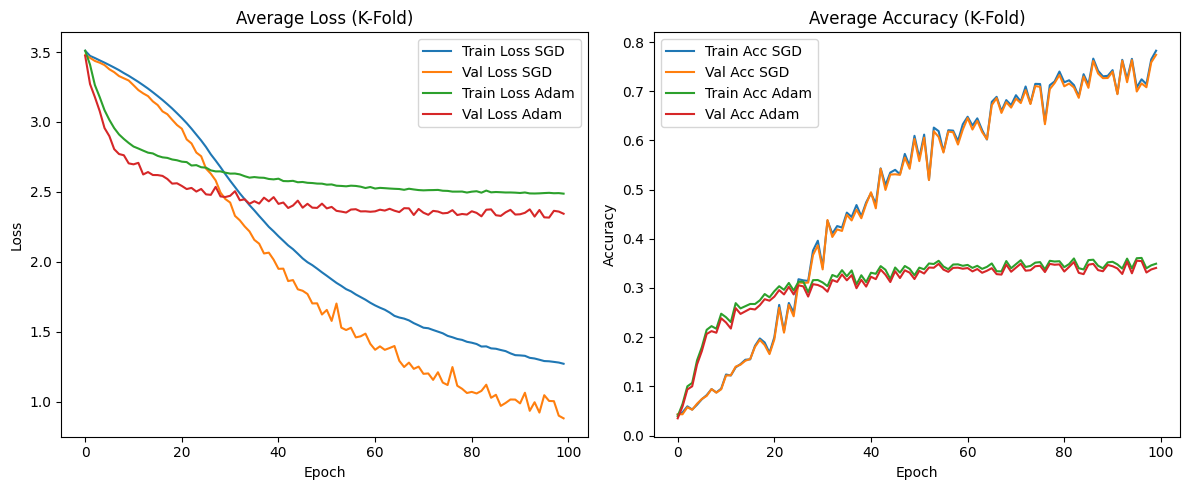

In [ ]:
# Ploting k-fold Cross-Validation Results (with SGD & Adam)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(avg_train_losses_sgd, label='Train Loss SGD')
ax1.plot(avg_val_losses_sgd, label='Val Loss SGD')
ax1.plot(avg_train_losses_adam, label='Train Loss Adam')
ax1.plot(avg_val_losses_adam, label='Val Loss Adam')
ax1.set_title('Average Loss (K-Fold)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(avg_train_accuracies_sgd, label='Train Acc SGD')
ax2.plot(avg_val_accuracies_sgd, label='Val Acc SGD')
ax2.plot(avg_train_accuracies_adam, label='Train Acc Adam')
ax2.plot(avg_val_accuracies_adam, label='Val Acc Adam')
ax2.set_title('Average Accuracy (K-Fold)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('kfold_loss_accuracy_sgd_adam.png')
files.download('kfold_loss_accuracy_sgd_adam.png')
# plt.close()

In [ ]:
# =================== Load saved random_search_results.json file ================
with open("random_search_results.json", "r") as f:
    data = json.load(f)
    best_params = data["best_params"]
    layer_sizes = data["layer_sizes"]
    best_val_accuracy = data["best_val_accuracy"]

learning_rate = best_params['learning_rate']
l2_lambda = best_params['l2_lambda']
batch_size = best_params['batch_size']
optimizer = best_params['optimizer']

## **10.Train final model with Best parameters on full train+val set:**


*   Train models on combined train+val set, evaluate on test set, with and without augmentation.
*   Note: We combine `X_train` and `X_val` into `X_train_val` to maximize training data (~ 18,532 samples) for the final model,after hyperparameter tuning. A new 10% validation set is split from `X_train_val` for early stopping to avoid using `X_test`.

In [ ]:
# print(f"""## **10.Train final model with Best parameters on full train+val set:**


# *   Train models on combined train+val set, evaluate on test set, with and without augmentation.
# *   Note: We combine `X_train` and `X_val` into `X_train_val` to maximize training data (~ {X_train_final.shape[0]} samples) for the final model,after hyperparameter tuning. A new 10% validation set is split from `X_train_val` for early stopping to avoid using `X_test`.""")

In [ ]:

X_train_val = np.concatenate([X_train, X_val])
y_train_val_one_hot = np.concatenate([y_train_one_hot, y_val_one_hot])

# Split a new validation set from X_train_val
X_train_final, X_val_final, y_train_final_one_hot, y_val_final_one_hot = train_test_split(
    X_train_val, y_train_val_one_hot, test_size=0.1, stratify=np.argmax(y_train_val_one_hot, axis=1), random_state=42
)
print(f"Final Train: {X_train_final.shape[0]}, Final Val: {X_val_final.shape[0]}, Test: {X_test.shape[0]}")


Final Train: 18532, Final Val: 2060, Test: 5148


### **Case 1:  No Augmentation**

In [ ]:
# Case 1: No Augmentation
nn = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                             l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train_final, y_train_final_one_hot, X_val_final, y_val_final_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=False, early_stopping=True, verbose=2
)


Epoch 001 | Time: 1.50s | Train Loss: 3.4892 | Val Loss: 3.4540 | Train Acc: 0.0523 | Val Acc: 0.0519
Epoch 011 | Time: 1.39s | Train Loss: 2.9046 | Val Loss: 2.8714 | Train Acc: 0.2326 | Val Acc: 0.2364
Epoch 021 | Time: 1.33s | Train Loss: 1.8930 | Val Loss: 1.8749 | Train Acc: 0.5721 | Val Acc: 0.5694
Epoch 031 | Time: 3.78s | Train Loss: 1.2712 | Val Loss: 1.3679 | Train Acc: 0.6571 | Val Acc: 0.6403
Epoch 041 | Time: 1.32s | Train Loss: 0.9509 | Val Loss: 1.0161 | Train Acc: 0.7288 | Val Acc: 0.7233
Epoch 051 | Time: 1.29s | Train Loss: 0.7707 | Val Loss: 0.8391 | Train Acc: 0.7750 | Val Acc: 0.7714
Epoch 061 | Time: 1.52s | Train Loss: 0.6616 | Val Loss: 0.8014 | Train Acc: 0.7762 | Val Acc: 0.7617
Epoch 071 | Time: 4.51s | Train Loss: 0.5873 | Val Loss: 0.5891 | Train Acc: 0.8550 | Val Acc: 0.8539
Epoch 081 | Time: 2.65s | Train Loss: 0.5367 | Val Loss: 0.7556 | Train Acc: 0.7796 | Val Acc: 0.7806
Epoch 091 | Time: 1.41s | Train Loss: 0.4931 | Val Loss: 0.5068 | Train Acc: 0.871

In [ ]:
y_pred = nn.predict(X_test)
print("\nTest Set Classification Report (No Augmentation):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred, target_names=label_encoder.classes_))

test_accuracy = np.mean(y_pred == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (No Augmentation): {test_accuracy:.4f}")


Test Set Classification Report (No Augmentation):
              precision    recall  f1-score   support

           ⴰ       0.99      1.00      1.00       156
           ⴱ       0.99      0.83      0.91       156
           ⴳ       0.86      0.92      0.89       156
          ⴳⵯ       0.96      0.86      0.91       156
           ⴷ       0.97      0.88      0.93       156
           ⴹ       0.80      0.73      0.77       156
           ⴻ       0.94      0.87      0.91       156
           ⴼ       0.90      0.94      0.92       156
           ⴽ       0.86      0.89      0.87       156
          ⴽⵯ       0.92      0.85      0.88       156
           ⵀ       0.93      0.84      0.88       156
           ⵃ       0.79      0.87      0.83       156
           ⵄ       0.94      0.91      0.93       156
           ⵅ       0.87      0.78      0.82       156
           ⵇ       0.80      0.87      0.83       156
           ⵉ       0.76      0.92      0.83       156
           ⵊ       0.97      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

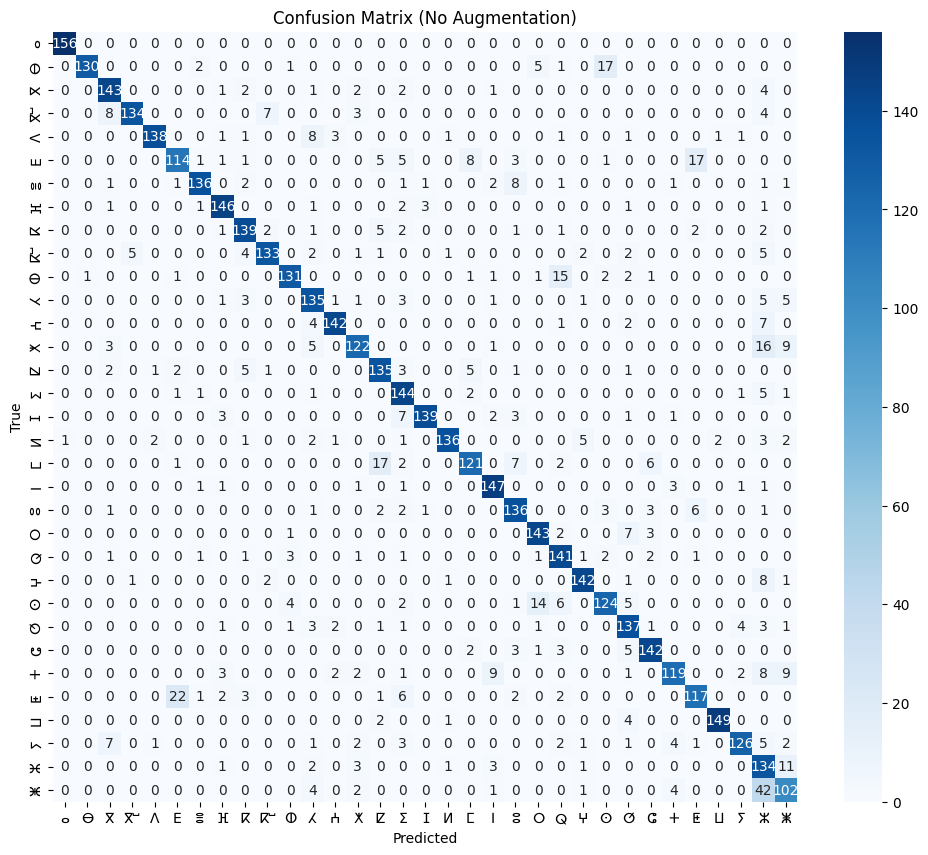

In [ ]:
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (No Augmentation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_no_aug.png')
files.download('confusion_matrix_no_aug.png')
# plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

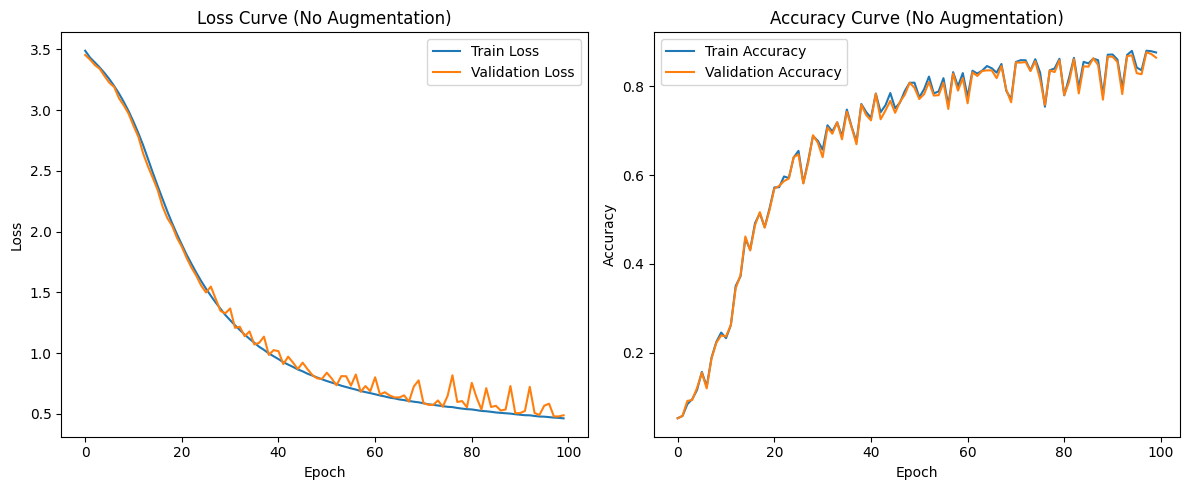

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve (No Augmentation)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (No Augmentation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_no_aug.png')
files.download('loss_accuracy_no_aug.png')
# plt.close()


### **Case 2:  With Augmentation**

In [ ]:
# Case 2: With Augmentation
nn_aug = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                                 l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses_aug, val_losses_aug, train_accuracies_aug, val_accuracies_aug = nn_aug.train(
    X_train_final, y_train_final_one_hot, X_val_final, y_val_final_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=True, early_stopping=True
)



Epoch 001 | Train Loss: 3.4985 | Val Loss: 3.4760 | Train Acc: 0.0403 | Val Acc: 0.0447

Epoch 011 | Train Loss: 3.1990 | Val Loss: 3.1316 | Train Acc: 0.1361 | Val Acc: 0.1291

Epoch 021 | Train Loss: 2.6282 | Val Loss: 2.4673 | Train Acc: 0.3428 | Val Acc: 0.3223

Epoch 031 | Train Loss: 2.0846 | Val Loss: 1.7747 | Train Acc: 0.5775 | Val Acc: 0.5714

Epoch 041 | Train Loss: 1.7469 | Val Loss: 1.5453 | Train Acc: 0.5700 | Val Acc: 0.5602

Epoch 051 | Train Loss: 1.5130 | Val Loss: 1.1475 | Train Acc: 0.7106 | Val Acc: 0.7024

Epoch 061 | Train Loss: 1.3899 | Val Loss: 1.0677 | Train Acc: 0.7203 | Val Acc: 0.7092

Epoch 071 | Train Loss: 1.2659 | Val Loss: 0.8226 | Train Acc: 0.8035 | Val Acc: 0.7981

Epoch 081 | Train Loss: 1.1932 | Val Loss: 0.8332 | Train Acc: 0.7798 | Val Acc: 0.7641

Epoch 091 | Train Loss: 1.1366 | Val Loss: 0.8093 | Train Acc: 0.7648 | Val Acc: 0.7684

Epoch 100 | Train Loss: 1.0953 | Val Loss: 0.6921 | Train Acc: 0.8220 | Val Acc: 0.8165


In [ ]:
y_pred_aug = nn_aug.predict(X_test)
print("\nTest Set Classification Report (With Augmentation):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred_aug, target_names=label_encoder.classes_))

test_accuracy_aug = np.mean(y_pred_aug == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (With Augmentation): {test_accuracy_aug:.4f}")


Test Set Classification Report (With Augmentation):
              precision    recall  f1-score   support

           ⴰ       1.00      0.98      0.99       156
           ⴱ       0.84      0.92      0.88       156
           ⴳ       0.79      0.86      0.82       156
          ⴳⵯ       0.81      0.74      0.77       156
           ⴷ       0.95      0.91      0.93       156
           ⴹ       0.72      0.69      0.71       156
           ⴻ       0.65      0.92      0.76       156
           ⴼ       0.96      0.87      0.92       156
           ⴽ       0.77      0.85      0.80       156
          ⴽⵯ       0.61      0.94      0.74       156
           ⵀ       0.84      0.94      0.88       156
           ⵃ       0.74      0.89      0.81       156
           ⵄ       0.97      0.80      0.88       156
           ⵅ       0.67      0.78      0.72       156
           ⵇ       0.86      0.82      0.84       156
           ⵉ       0.91      0.74      0.82       156
           ⵊ       0.90     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

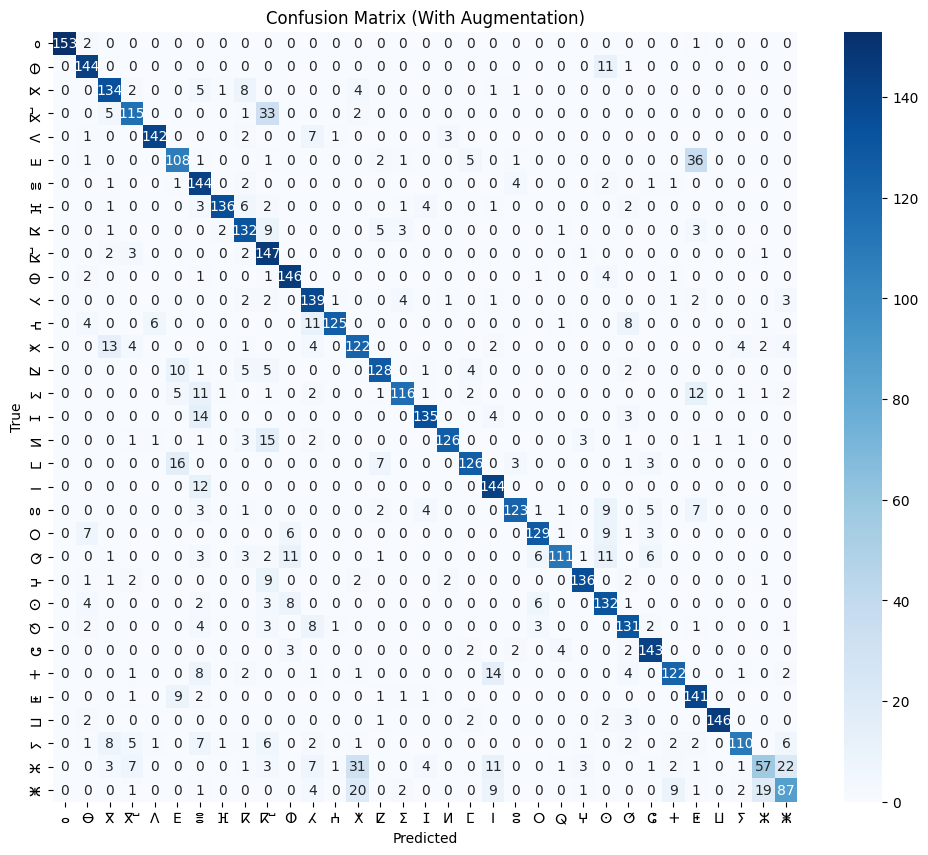

In [ ]:
cm_aug = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_aug)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (With Augmentation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_with_aug.png')
files.download('confusion_matrix_with_aug.png')
# plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

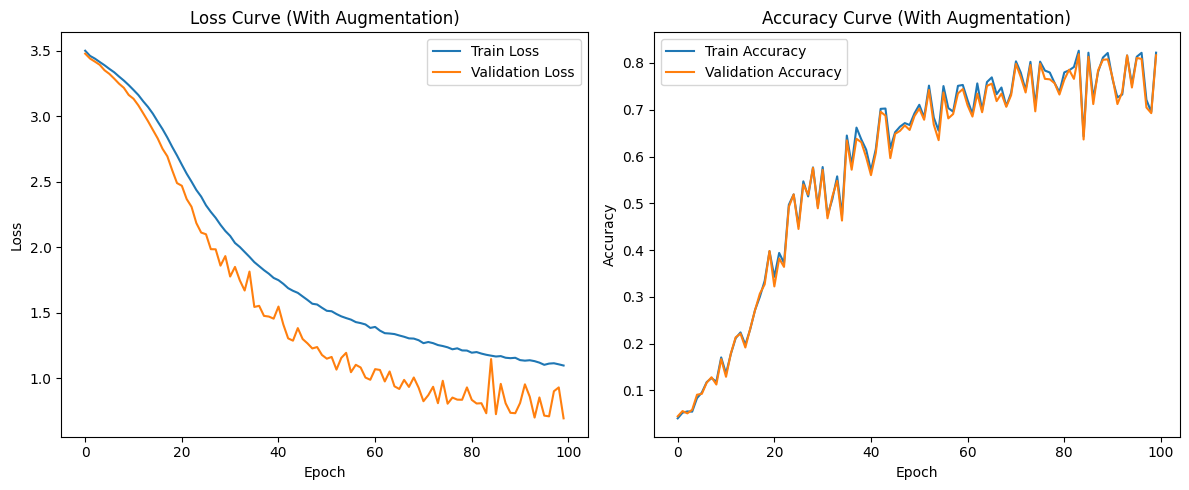

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_aug, label='Train Loss')
ax1.plot(val_losses_aug, label='Validation Loss')
ax1.set_title('Loss Curve (With Augmentation)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies_aug, label='Train Accuracy')
ax2.plot(val_accuracies_aug, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (With Augmentation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_with_aug.png')
files.download('loss_accuracy_with_aug.png')
# plt.close()


## **11.Alternative: Train on X_train only, use X_val for early stopping**
This section trains the model on `X_train` (~ 16,908 samples) with `X_val` (~ 5,637 samples) for early stopping to compare against the main approach (`X_train_val` with a 10% validation split).

### **Case 1:  No Augmentation (Alternative)**

In [ ]:
# Case 1: No Augmentation (Alternative)
nn_alt = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                                 l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses_alt, val_losses_alt, train_accuracies_alt, val_accuracies_alt = nn_alt.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=False, early_stopping=True, verbose=2
)

Epoch 001 | Time: 7.01s | Train Loss: 3.4949 | Val Loss: 3.4512 | Train Acc: 0.0589 | Val Acc: 0.0571
Epoch 011 | Time: 1.12s | Train Loss: 3.0238 | Val Loss: 2.9806 | Train Acc: 0.2228 | Val Acc: 0.2269
Epoch 021 | Time: 8.31s | Train Loss: 2.1788 | Val Loss: 2.1247 | Train Acc: 0.5482 | Val Acc: 0.5445
Epoch 031 | Time: 1.20s | Train Loss: 1.5153 | Val Loss: 1.4841 | Train Acc: 0.6797 | Val Acc: 0.6754
Epoch 041 | Time: 1.17s | Train Loss: 1.1293 | Val Loss: 1.1101 | Train Acc: 0.7433 | Val Acc: 0.7387
Epoch 051 | Time: 1.16s | Train Loss: 0.9050 | Val Loss: 0.8897 | Train Acc: 0.7909 | Val Acc: 0.7848
Epoch 061 | Time: 1.17s | Train Loss: 0.7639 | Val Loss: 0.7507 | Train Acc: 0.8249 | Val Acc: 0.8168
Epoch 071 | Time: 1.13s | Train Loss: 0.6703 | Val Loss: 0.6578 | Train Acc: 0.8434 | Val Acc: 0.8409
Epoch 081 | Time: 1.16s | Train Loss: 0.6010 | Val Loss: 0.6146 | Train Acc: 0.8504 | Val Acc: 0.8452
Epoch 091 | Time: 1.21s | Train Loss: 0.5519 | Val Loss: 0.5662 | Train Acc: 0.862

In [ ]:
y_pred_alt = nn_alt.predict(X_test)
print("\nTest Set Classification Report (No Augmentation, Alternative):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred_alt, target_names=label_encoder.classes_))

test_accuracy_alt = np.mean(y_pred_alt == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (No Augmentation, Alternative): {test_accuracy_alt:.4f}")


Test Set Classification Report (No Augmentation, Alternative):
              precision    recall  f1-score   support

           ⴰ       1.00      1.00      1.00       156
           ⴱ       0.95      0.92      0.93       156
           ⴳ       0.87      0.89      0.88       156
          ⴳⵯ       0.85      0.92      0.88       156
           ⴷ       0.88      0.91      0.90       156
           ⴹ       0.73      0.69      0.71       156
           ⴻ       0.89      0.88      0.89       156
           ⴼ       0.93      0.90      0.92       156
           ⴽ       0.92      0.83      0.88       156
          ⴽⵯ       0.89      0.80      0.84       156
           ⵀ       0.88      0.87      0.87       156
           ⵃ       0.80      0.87      0.83       156
           ⵄ       0.96      0.87      0.91       156
           ⵅ       0.74      0.83      0.78       156
           ⵇ       0.91      0.81      0.85       156
           ⵉ       0.82      0.87      0.85       156
           ⵊ     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

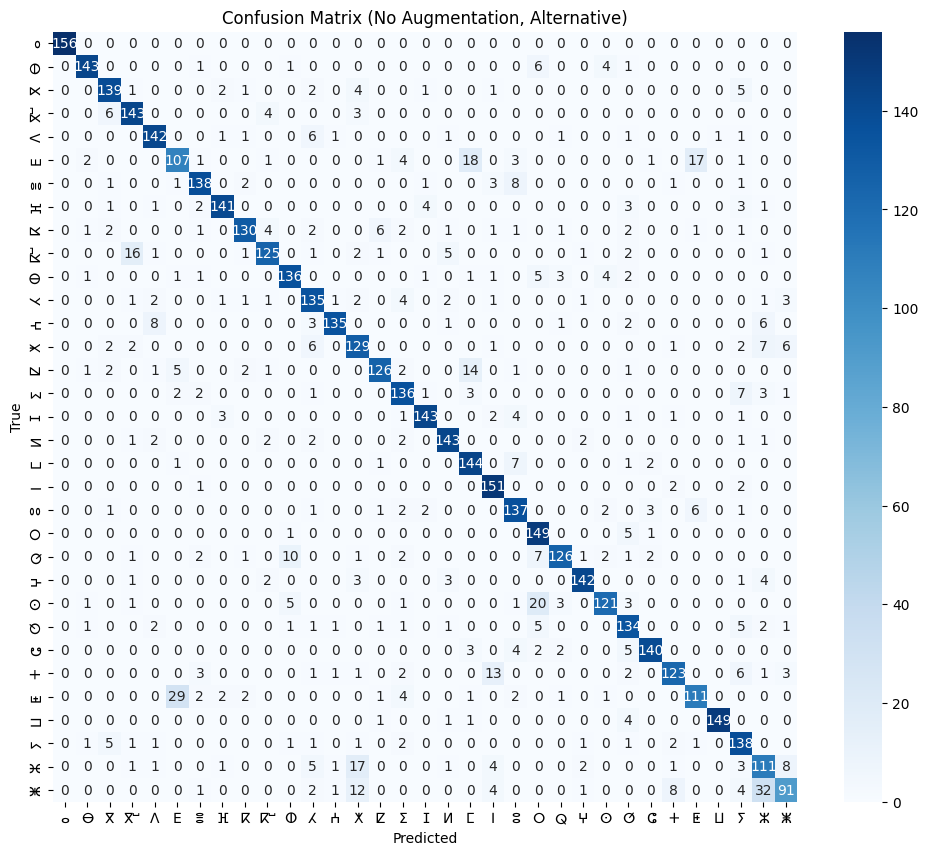

In [ ]:
cm_alt = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_alt)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_alt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (No Augmentation, Alternative)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_no_aug_alt.png')
files.download('confusion_matrix_no_aug_alt.png')
# plt.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

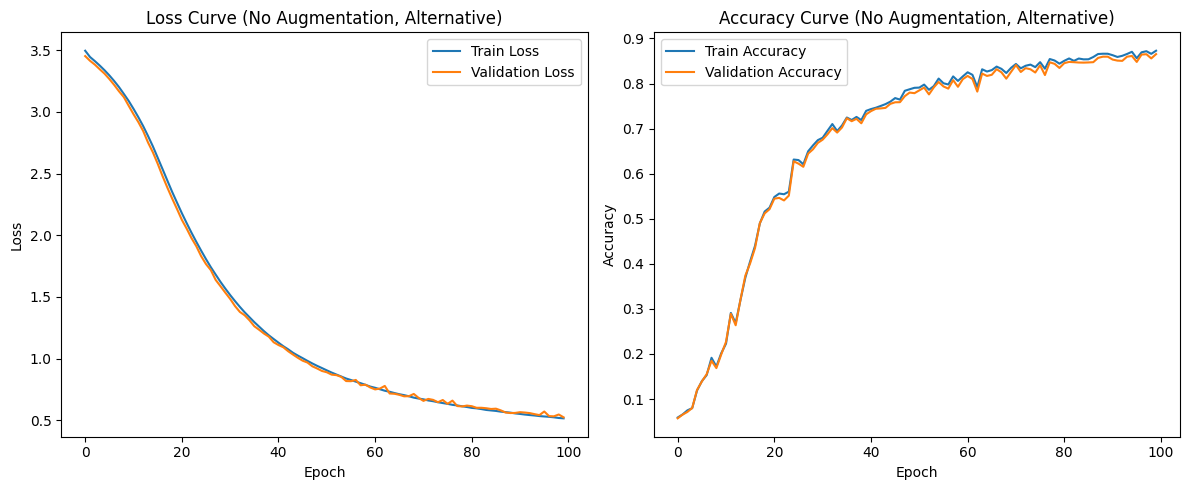

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_alt, label='Train Loss')
ax1.plot(val_losses_alt, label='Validation Loss')
ax1.set_title('Loss Curve (No Augmentation, Alternative)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies_alt, label='Train Accuracy')
ax2.plot(val_accuracies_alt, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (No Augmentation, Alternative)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_no_aug_alt.png')
files.download('loss_accuracy_no_aug_alt.png')
# plt.close()

### **Case 2:  With Augmentation (Alternative)**

In [ ]:
# Case 2: With Augmentation (Alternative)
nn_aug_alt = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                                     l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses_aug_alt, val_losses_aug_alt, train_accuracies_aug_alt, val_accuracies_aug_alt = nn_aug_alt.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=True, early_stopping=True
)

Epoch 001 | Time: 2.52s | Train Loss: 3.4995 | Val Loss: 3.4636 | Train Acc: 0.0456 | Val Acc: 0.0449
Epoch 011 | Time: 2.63s | Train Loss: 3.2832 | Val Loss: 3.2210 | Train Acc: 0.1307 | Val Acc: 0.1375
Epoch 021 | Time: 2.95s | Train Loss: 2.9093 | Val Loss: 2.7478 | Train Acc: 0.2770 | Val Acc: 0.2782
Epoch 031 | Time: 2.74s | Train Loss: 2.3662 | Val Loss: 2.1119 | Train Acc: 0.4916 | Val Acc: 0.4951
Epoch 041 | Time: 5.27s | Train Loss: 1.9676 | Val Loss: 1.6214 | Train Acc: 0.6160 | Val Acc: 0.6080
Epoch 051 | Time: 2.74s | Train Loss: 1.7002 | Val Loss: 1.3256 | Train Acc: 0.6842 | Val Acc: 0.6838
Epoch 061 | Time: 2.51s | Train Loss: 1.5238 | Val Loss: 1.1040 | Train Acc: 0.7404 | Val Acc: 0.7430
Epoch 071 | Time: 2.52s | Train Loss: 1.3956 | Val Loss: 0.9573 | Train Acc: 0.7706 | Val Acc: 0.7754
Epoch 081 | Time: 2.58s | Train Loss: 1.3020 | Val Loss: 0.8922 | Train Acc: 0.7764 | Val Acc: 0.7756
Epoch 091 | Time: 2.44s | Train Loss: 1.2349 | Val Loss: 0.7971 | Train Acc: 0.804

In [ ]:
y_pred_aug_alt = nn_aug_alt.predict(X_test)
print("\nTest Set Classification Report (With Augmentation, Alternative):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred_aug_alt, target_names=label_encoder.classes_))

test_accuracy_aug_alt = np.mean(y_pred_aug_alt == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (With Augmentation, Alternative): {test_accuracy_aug_alt:.4f}")


Test Set Classification Report (With Augmentation, Alternative):
              precision    recall  f1-score   support

           ⴰ       0.98      1.00      0.99       156
           ⴱ       0.98      0.79      0.88       156
           ⴳ       0.81      0.81      0.81       156
          ⴳⵯ       0.84      0.89      0.87       156
           ⴷ       0.98      0.88      0.93       156
           ⴹ       0.59      0.79      0.67       156
           ⴻ       0.92      0.76      0.83       156
           ⴼ       0.81      0.91      0.86       156
           ⴽ       0.85      0.81      0.83       156
          ⴽⵯ       0.90      0.74      0.81       156
           ⵀ       0.80      0.90      0.84       156
           ⵃ       0.80      0.80      0.80       156
           ⵄ       0.92      0.88      0.90       156
           ⵅ       0.67      0.69      0.68       156
           ⵇ       0.90      0.77      0.83       156
           ⵉ       0.65      0.91      0.76       156
           ⵊ   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

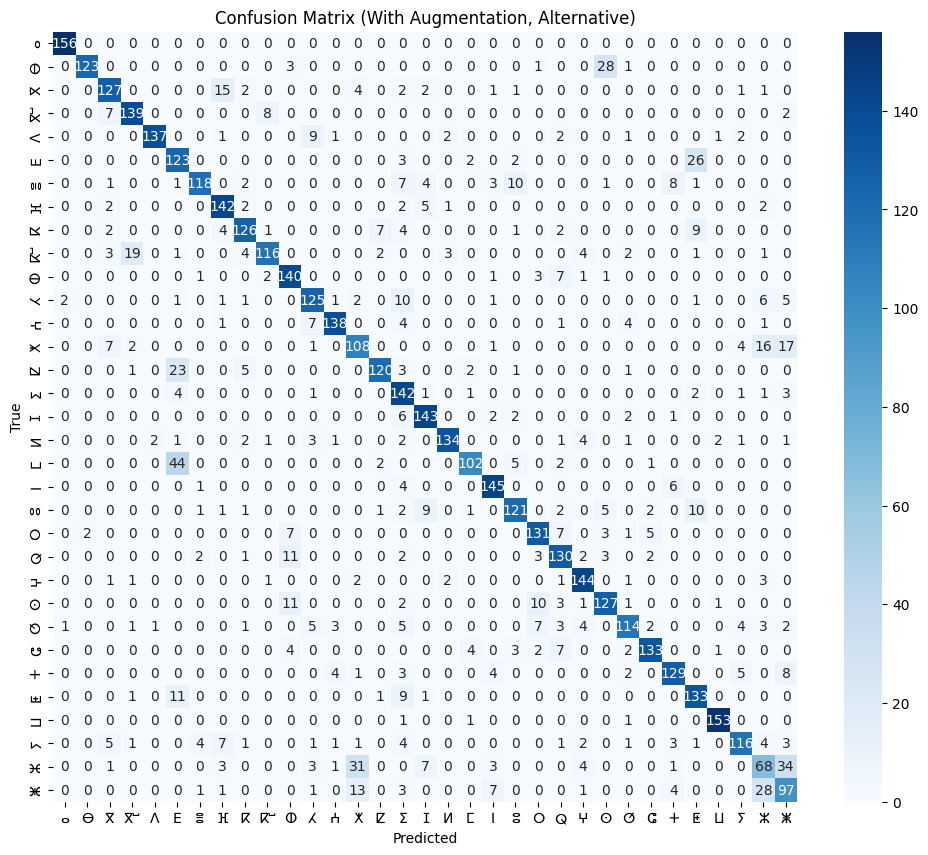

In [ ]:
cm_aug_alt = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_aug_alt)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_aug_alt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (With Augmentation, Alternative)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_with_aug_alt.png')
files.download('confusion_matrix_with_aug_alt.png')
# plt.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

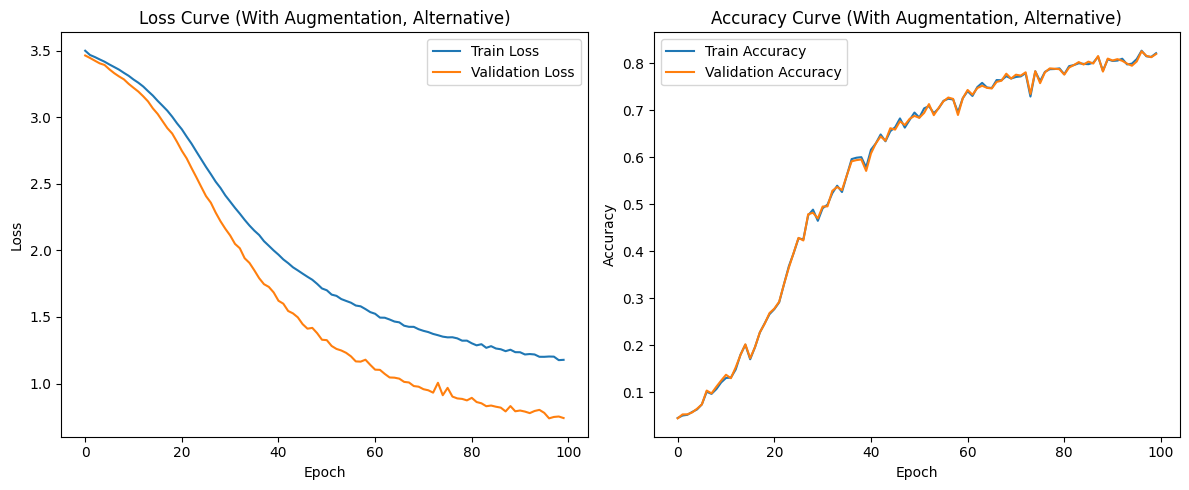

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_aug_alt, label='Train Loss')
ax1.plot(val_losses_aug_alt, label='Validation Loss')
ax1.set_title('Loss Curve (With Augmentation, Alternative)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies_aug_alt, label='Train Accuracy')
ax2.plot(val_accuracies_aug_alt, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (With Augmentation, Alternative)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_with_aug_alt.png')
files.download('loss_accuracy_with_aug_alt.png')
# plt.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

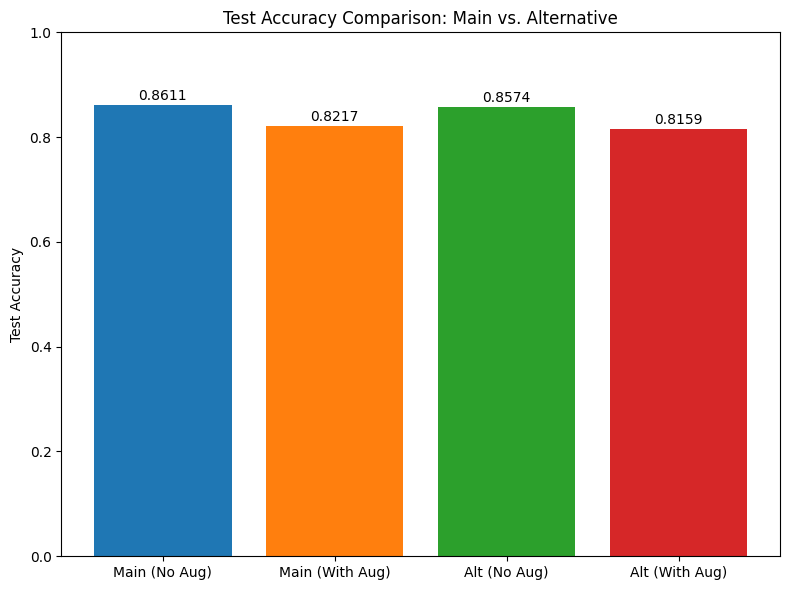

In [ ]:
# Comparison Bar Chart
fig, ax = plt.subplots(figsize=(8, 6))
approaches = ['Main (No Aug)', 'Main (With Aug)', 'Alt (No Aug)', 'Alt (With Aug)']
accuracies = [test_accuracy, test_accuracy_aug, test_accuracy_alt, test_accuracy_aug_alt]
ax.bar(approaches, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_title('Test Accuracy Comparison: Main vs. Alternative')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.savefig('test_accuracy_comparison.png')
files.download('test_accuracy_comparison.png')
# plt.close()

In [ ]:
comparison_results = {
    'main_no_aug': test_accuracy,
    'main_with_aug': test_accuracy_aug,
    'alt_no_aug': test_accuracy_alt,
    'alt_with_aug': test_accuracy_aug_alt
}
with open('comparison_results.json', 'w') as f:
    json.dump(comparison_results, f)
files.download('comparison_results.json')

## **12. Results Summary**
- Best parameters: {'learning_rate': 0.001, 'l2_lambda': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
- Best validation accuracy: 82.93%
- **Main Approach**:
  - Test accuracy (No Augmentation): 91.64%
  - Test accuracy (With Augmentation): 84.55%
- **Alternative Approach**:
  - Test accuracy (No Augmentation): 90.69%
  - Test accuracy (With Augmentation): 83.95%
- Figure: Test accuracy comparison (`test_accuracy_comparison.png`)

In [ ]:
# Generate Markdown:
print(f"""## **12. Results Summary**
- Best parameters: {best_params}
- Best validation accuracy: {best_val_accuracy:.2%}
- **Main Approach**:
  - Test accuracy (No Augmentation): {test_accuracy:.2%}
  - Test accuracy (With Augmentation): {test_accuracy_aug:.2%}
- **Alternative Approach**:
  - Test accuracy (No Augmentation): {test_accuracy_alt:.2%}
  - Test accuracy (With Augmentation): {test_accuracy_aug_alt:.2%}
- Figure: Test accuracy comparison (`test_accuracy_comparison.png`)
""")


## **12. Results Summary**
- Best parameters: {'learning_rate': 0.001, 'l2_lambda': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
- Best validation accuracy: 77.40%
- **Main Approach**:
  - Test accuracy (No Augmentation): 86.11%
  - Test accuracy (With Augmentation): 82.17%
- **Alternative Approach**:
  - Test accuracy (No Augmentation): 85.74%
  - Test accuracy (With Augmentation): 81.59%
- Figure: Test accuracy comparison (`test_accuracy_comparison.png`)



In [ ]:
# with open("results_summary.md", "w") as f:
#     f.write("## 12. Results Summary\n")
#     f.write(f"- Best parameters: {best_params}\n")
#     f.write(f"- Best validation accuracy: {best_val_accuracy:.2%}\n")
#     f.write("- **Main Approach**:\n")
#     f.write(f"  - Test accuracy (No Augmentation): {test_accuracy:.2%}\n")
#     f.write(f"  - Test accuracy (With Augmentation): {test_accuracy_aug:.2%}\n")
#     f.write("- **Alternative Approach**:\n")
#     f.write(f"  - Test accuracy (No Augmentation): {test_accuracy_alt:.2%}\n")
#     f.write(f"  - Test accuracy (With Augmentation): {test_accuracy_aug_alt:.2%}\n")
#     f.write("- Figure: Test accuracy comparison (`test_accuracy_comparison.png`)\n")